### Collaborative Active Learning for Drug Discovery

In [1]:
import os
import json
import numpy as np
import pandas as pd
from zipfile import ZipFile
from copy import deepcopy

#### Loading drug/target interaction (DTI) data
- `X_drug`: Simplified Molecular-Input Line-Entry System (SMILES) string that describes molecule structures of drugs.
- `X_target`: Target amino acid sequence (Target sites for drugs).
- `y`: Affinity score between the drug and target; when binary, set $y=0$ for $\text{affinity}<\text{threshold}$ and $y=1$ otherwise.

**Our task: for a specific amino acid site we want to target, find a suitable drug that binds (thus acts) well on the target site.**

In [2]:
def convert_y_unit(y, from_, to_):
	array_flag = False
	if isinstance(y, (int, float)):
		y = np.array([y])
		array_flag = True
	y = y.astype(float)    
	# basis as nM
	if from_ == 'nM':
		y = y
	elif from_ == 'p':
		y = 10**(-y) / 1e-9

	if to_ == 'p':
		zero_idxs = np.where(y == 0.)[0]
		y[zero_idxs] = 1e-10
		y = -np.log10(y*1e-9)
	elif to_ == 'nM':
		y = y
        
	if array_flag:
		return y[0]
	return y

def load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30):
    print('Beginning Processing...')

    if not os.path.exists(path):
        os.makedirs(path)

    saved_path = './data/DAVIS_raw.zip'

    ## IMPORTANT: Download the DAVIS dataset file from 'https://github.com/futianfan/DeepPurpose_Data/blob/main/DAVIS.zip?raw=true'
    ## and place the dataset file in the './data/' folder. Extract the zip file using the code below
    # print('Beginning to extract zip file...')
    # with ZipFile(saved_path, 'r') as zip:
    #     zip.extractall(path = path)

    affinity = pd.read_csv(path + '/DAVIS/affinity.txt', header=None, sep = ' ')

    with open(path + '/DAVIS/target_seq.txt') as f:
        target = json.load(f)

    with open(path + '/DAVIS/SMILES.txt') as f:
        drug = json.load(f)

    target = list(target.values())
    drug = list(drug.values())

    SMILES = []
    Target_seq = []
    y = []

    for i in range(len(drug)):
        for j in range(len(target)):
            SMILES.append(drug[i])
            Target_seq.append(target[j])
            y.append(affinity.values[i, j])

    if binary:
        print('Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter')
        y = [1 if i else 0 for i in np.array(y) < threshold]
    else:
        if convert_to_log:
            print('Default set to logspace (nM -> p) for easier regression')
            y = convert_y_unit(np.array(y), 'nM', 'p')
        else:
            y = y
    print('Done!')
    return np.array(SMILES), np.array(Target_seq), np.array(y)

In [3]:
X_drug, X_target, y = load_process_DAVIS('./data/', binary=True)
print('Setting the target site to be the amino acid with sequence "{}"'.format(X_target[1]))
idx = X_target==X_target[1]
X_drug, X_target, y = X_drug[idx], X_target[idx], y[idx]

Beginning Processing...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!
Setting the target site to be the amino acid with sequence "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGH

In [4]:
# Unique X_drug to a specific X_target, y is binary
idx = np.unique(X_drug, return_index=True)[1]
X_drug, X_target, y = X_drug[idx], X_target[idx], y[idx]

#### Define the kernel for DTI
Since the `X_drug` is in the form of strings, we need to use string kernels here.
- Mismatch: $(k,m)$-mismatch kernel ($k$ for length of compared substrings, $m$ for # of mismatches allowed)
- Subsequence: Gap-weighted subsequences kernels

In [5]:
import numpy as np
import re

class Kernel():
    def __init__(self, kernel = None, y_true = None):
        self.check_size(kernel)
        self.kernel = kernel
        self.y_true = y_true
    
    @classmethod    
    def get_kernel(cls, path):
        kernel = []
        with open (path) as input:
            for line in input:
                # delete blank lines or lines of all 0's
                if re.match(r'^\s*$', line) or float(line.split(' ')[0]) - 0 < 0.00001:
                    continue
                kernel.append(list(map(float,line.strip().split(' '))))
        kernel = np.array(kernel)
        return (kernel)

    @classmethod
    def subseq_helper(cls, smiles, **kwargs):
        lamda = kwargs['lamda'] if 'lamda' in kwargs else None            
        p = kwargs['p'] if 'p' in kwargs else None
        tune = kwargs['p'] if 'tune' in kwargs else None

        if not tune:
            if lamda and p:
                K= gws(smiles, p, lamda)
            elif lamda:
                K = gws(smiles, 4, lamda)
            elif p:
                K = gws(smiles, p, 0.8)
            else:
                K = gws(smiles)
        else:   # tune both parameters
            K = gws(smiles, None, None, True)
            
        return (K)

    @classmethod
    def mismatch_helper(cls, smiles, **kwargs):
        k = kwargs['k'] if 'k' in kwargs else None
        m = kwargs['m'] if 'm' in kwargs else None

        if k and m:
            K = mismatch(smiles, k, m)
        elif k:
            K = mismatch(smiles, k, 1)
        elif m:
            K = mismatch(smiles, 4, m)
        else:
            K = mismatch(smiles)

        return (K)
    
    def check_size(self, K):
        if K.shape[0] != K.shape[1]:
            raise Exception("The Gram matrix doesn't have correct size.")

    @classmethod
    def from_file(cls, path, y_true):
        K = cls.get_kernel(path)
        return cls(K, y_true)
    
    @classmethod
    def from_smi(cls, smiles, y_true, kern_type, **kwargs):

        # string kernel
        if kern_type == 'subsequence':
            K = cls.subseq_helper(smiles, **kwargs)    
            return (cls(K, y_true))            
            
        # mismatch kernel
        if kern_type == 'mismatch':
            K = cls.mismatch_helper(smiles, **kwargs)
            return (cls(K, y_true))


In [6]:
import math
# mismatch kernel
# k for length of compared substrings, m for # of mismatches allowed
def mismatch(smiles, k = 4, m = 1):
    N = len(smiles)
    count_tree = mismatch_count(smiles, k, m)
    gram = mismatch_matrix(count_tree, N)
    return (gram)

def mismatch_count(smiles, k = 5, m = 1):
    # construct the alphabet for smiles representation of mols
    alphabet = set()
    for smile in smiles:
        for c in smile:
            alphabet.add(c)

    # compute the dict for counting characters (l=1)
    N = len(smiles)
    t1 = {i:{} for i in alphabet}
    for x in alphabet:
        for i in range(N):
            for j in range(len(smiles[i])):
                t1[x][(i,j)] = 0 if smiles[i][j] == x else 1
    
    prev = t1
    
    for i in range(1, k - 1):
        cur = {}
        for key in prev:
            for c in alphabet:                
                temp = tuple(list(key) + [c])  # potential substrings
                for key2 in prev[key]:
                    i, j = key2
                    if prev[key][key2] <= m and j <= len(smiles[i]) - 2:                
                        if temp not in cur:
                            cur[temp] = {}
                        count = prev[key][key2] if smiles[i][j+1] == c else prev[key][key2] + 1  # count mismatches
                        if count <= m:
                            cur[temp][(i,j+1)] = count
        prev = cur
                            
    count_tree = {}
    for key in prev:
        for c in alphabet:
            temp = tuple(list(key) + [c])
            for key2 in prev[key]:
                i, j = key2
                if prev[key][key2] <= m and j <= len(smiles[i]) - 2:                
                    if temp not in count_tree:
                        count_tree[temp] = {}
                    if i not in count_tree[temp]:
                        count_tree[temp][i] = {}
                    count = prev[key][key2] if smiles[i][j+1] == c else prev[key][key2] + 1
                    if count <= m:
                        count_tree[temp][i][j+1] = count
    return (count_tree) 

def mismatch_matrix(count_tree, N):
    # compute gram matrix                    
    K = np.zeros((N,N))
    for key1 in count_tree:
        l = count_tree[key1].keys()
        for i in l:
            for j in l:
                K[i, j] += len(count_tree[key1][i].keys()) * len(count_tree[key1][j].keys())
                
    # normalize
    gram = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            gram[i,j] = K[i,j] / math.sqrt(K[i,i] * K[j,j])
            
    return (gram)

In [7]:
# Gap-weighted subsequences kernels
# Input: strings s and t of lengths n and m, length p, weight λ
def gws_kern(mol1, mol2, p, lamda):
    n = len(mol1)
    m = len(mol2)
    DPS = np.zeros((n, m))
    kern = [0]*p
    
    for i in range(n):
        for j in range(m):
            if mol1[i] == mol2[j]:
                DPS[i,j] = lamda**2
        
    kern[0] = np.sum(DPS)
    DP = np.zeros((n-1, m-1))
    for l in range(1,p):
        DP[0,0] = DPS[0,0]
        # boundary values
        for i in range(1,n-1):
            DP[i,0] = DPS[i,0] + lamda * DP[i-1,0]
        for j in range(1,m-1):
            DP[0,j] = DPS[0,j] + lamda * DP[0,j-1]
            
        # update DP
        for i in range(1,n-1):
            for j in range(1,m-1):
                DP[i,j] = DPS[i,j] + lamda * DP[i-1,j] + lamda * DP[i,j-1] + (lamda**2) * DP[i-1,j-1]
            
        # update DPS and kernel value
        for i in range(1,n):
            for j in range(1,m):
                if mol1[i] == mol2[j]:
                    DPS[i,j] = (lamda**2) * DP[i-1,j-1]
                    kern[l] = kern[l] + DPS[i,j]
                    
    return (kern)


def gws_matrix(smiles, p, lamda):
    kern = [[] for _ in range(p)]
    for i in range(len(smiles)):
        temp = gws_kern(smiles[i],smiles[i],p,lamda)
        for l in range(p):
            # compute square root here
            kern[l].append(math.sqrt(temp[l]))
    
    sim = [[] for _ in range(p)]
    for i in range(len(smiles)):
        for l in range(p):
            sim[l].append([])
        for j in range(len(smiles)):
            temp = gws_kern(smiles[i],smiles[j],p,lamda)
            for l in range(p):
                # normalize
                sim[l][i].append(temp[l]/(kern[l][i]*kern[l][j]))
                
    str_kern = np.array(sim)
    return (str_kern)


def gws(smiles, p = 4, lamda = 0.8, tune = False):
    if not tune:
        gram = gws_matrix(smiles, p, lamda)[p-1]
        return (gram)

In [8]:
kernel_name = 'subsequence' ## or 'mismatch'

if kernel_name == 'subsequence':
    subsequence = Kernel.from_smi(X_drug, y, 'subsequence')
    kernel_matrix = subsequence.kernel
elif kernel_name == 'mismatch':
    mismatch = Kernel.from_smi(X_drug, y, 'mismatch')
    kernel_matrix = mismatch.kernel
else:
    raise NotImplementedError()

inputs = X_drug

kernel_dict = dict()
for i in range(len(inputs)):
    kernel_dict[inputs[i]] = i

def kernel_func(x1, x2):
    matrix = np.zeros((len(x1), len(x2)))

    for i in range(len(x1)):
        for j in range(len(x2)):
            matrix[i, j] = kernel_matrix[kernel_dict[x1[i]], kernel_dict[x2[j]]]

    return matrix

kernel = kernel_func

#### CAL

In [18]:
from utils.utils import cwd, set_up_plotting
from itertools import product

plt = set_up_plotting()

def posterior_predictive(X, X_train, Y_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X)
    K_ss = kernel(X, X)
    
    K_inv = np.linalg.inv(K + 1e-6 * np.eye(len(K)))

    mu_s = K_s.T @ K_inv @ Y_train
    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return mu_s, cov_s


def posterior_covariance(X, X_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + np.square(sigma_y) * np.eye(len(X_train))
    K_s = kernel(X_train, X)
    K_ss = kernel(X, X)
    K_inv = np.linalg.inv(K + 1e-6 * np.eye(len(K)))

    cov_s = K_ss - K_s.T @ K_inv @ K_s

    return cov_s

def IG_sum(acquired_obs, Ts, prior_logdets, alphas):
    
    return sum(_IG(acquired_obs, T, prior_logdet) *1.0 / alpha for T, prior_logdet, alpha in zip(Ts, prior_logdets, alphas) )

def _IG(acquired_obs, T, prior_logdet):
    post_cov = posterior_covariance(X=T, X_train=acquired_obs)
    _ , post_logdet = np.linalg.slogdet(post_cov)
    return 0.5 * (prior_logdet - post_logdet)

def coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[], d=1):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        assert len(alphas) == len(Ts)
        alphas = np.asarray(alphas) / sum(alphas)
        
    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs])

            delta_IG = IG_sum(temp_obs, Ts, prior_logdets, alphas) - prev_IG
            # the weighted sum of difference in IG_k - IG_{k-1} in Equation (2)
            
            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_])
        
        prev_IG = IG_sum(acquired_obs, Ts, prior_logdets, alphas)
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx]

    return acquired_obs

def coordinated_joint(Ss, joint_target, budget, prior_logdet_joint, subset_size=1000, d=1):
    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
              
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs])
            
            delta_IG = _IG(temp_obs, joint_target, prior_logdet_joint) - prev_IG
            
            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs
        
        acquired_obs = np.append(acquired_obs, [obs_])               
        
        prev_IG = _IG(acquired_obs, joint_target, prior_logdet_joint)

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx]

    return acquired_obs


def coordinated_random(Ss, Ts, budget, prior_logdets, d=1):
    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)
    
    for _ in range(budget):

        full_cartesian = np.asarray(list(product(*Supports)))
        
        obs_ = full_cartesian[np.random.choice(len(full_cartesian), size=1, replace=False)].squeeze()
        acquired_obs = np.append(acquired_obs, [obs_])

        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx]

    return acquired_obs

def entropy_sum(acquired_obs, Ts, alphas=[]):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        alphas = np.asarray(alphas)
    
    return sum(_entropy(acquired_obs, T) *1.0 / alpha for T, alpha in zip(Ts, alphas) )

def _entropy(acquired_obs, T):
    '''
    Note this is not the exact differential entropy formula, 
    instead it ignores some constant terms including the dimension d of data.
    
    For the purpose of maximum entropy search, it is sufficient since we only need the rank and not the 
    absolute value of entropy.
    '''
    post_cov = posterior_covariance(T, acquired_obs)
    _ , post_logdet = np.linalg.slogdet(post_cov)
    
    return post_logdet


def coordinated_entropy(Ss, Ts, budget, subset_size=1000, d=1):
    acquired_obs = np.asarray([])
    
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        obs_ = None
        
        entropy_max = -float('inf')

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]

        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs])

            curr_entropy = entropy_sum(temp_obs, Ts)
            
            if curr_entropy > entropy_max:
                entropy_max = curr_entropy
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_])
        
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            remove_idx = np.argwhere((S == ob).all(-1))
            keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
            Supports[i] = S[keep_idx]

    return acquired_obs

def individual_greedy(S, T, prior_logdet, budget, d=1, subset_size=1000):
        
    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Support = (S)
    IG_trail = []
    for _ in range(budget):
        delta_IG_max = -float('inf')
        obs_ = None
        prev_IG = 0
        
        subset_size = min(subset_size, len(Support))
        sub_support = Support[np.random.choice(len(Support), size=subset_size, replace=False)]
        for obs in sub_support:        
            temp_obs = np.append(acquired_obs, [obs])

            delta_IG = _IG(temp_obs, T, prior_logdet) - prev_IG

            if delta_IG > delta_IG_max:
                delta_IG_max = delta_IG
                obs_ = obs

        IG_trail.append(delta_IG_max)
        acquired_obs = np.append(acquired_obs, [obs_])
        prev_IG = _IG(acquired_obs, T, prior_logdet)

        # Support = S[S!= obs_].reshape(-1,d)
        remove_idx = np.argwhere((S == obs_).all(-1))
        keep_idx = np.setdiff1d(np.arange(len(S)), remove_idx)
        Support = S[keep_idx]

    return acquired_obs, IG_trail

def get_IG_trails(obs, Ts, prior_logdets, alphas=[]):
    if len(alphas) == 0:
        alphas = np.ones(len(Ts)) / len(Ts)
    else:
        assert len(alphas) == len(Ts)
        alphas = np.asarray(alphas) / sum(alphas)
        
    IG_sep_trail, IG_sum_trail = [], []

    acquired_obs = np.asarray([])
    
    for ob in obs:
        curr_IG_sep = []

        acquired_obs = np.append(acquired_obs, [ob])
        for i, (T, prior_logdet) in enumerate(zip(Ts, prior_logdets)):

            IG_i = _IG(acquired_obs, T, prior_logdet)
            curr_IG_sep.append(IG_i)
        IG_sep_trail.append(curr_IG_sep)
        
        IG_sum_trail.append(sum(IG*1.0/alpha for alpha, IG in zip(alphas, curr_IG_sep)) )

    return IG_sep_trail, IG_sum_trail

def coordinated_greedy_IG_sum(Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], d=1):
    '''
    Greedily maximizing the total sum of IGs in coordination instead of the marginal to the total sum of IGs 
    as in coordinated_greedy().
    
    This method does NOT satisfy near-optimality guarantee but may help with "cumulative" fairness of overall
    IGs.
    
    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs])

            IG_sum_curr = IG_sum(temp_obs, Ts, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

#         print("budget: {}".format(_), IG_max, obs_)
        acquired_obs = np.append(acquired_obs, [obs_])
                
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob]

    return acquired_obs

from scipy.special import softmax
def coordinated_dynamic_beta(Ss, Ts, budget, prior_logdets, subset_size=1000, betas=[], beta_coef=0.5, d=1):
    '''
    The beta values are dynamically updated according to the latest IGs of the agents to help improve
    "cumulative" fairness.

    
    '''
    betas = _check_betas(n=len(Ts), betas=betas)

    acquired_obs = np.asarray([])
    # supports is a copy of Ss so we do not need to repeatedly initialize Ss
    Supports = deepcopy(Ss)

    for _ in range(budget):
        IG_sum_max = -float('inf')
        obs_ = None

        full_cartesian = np.asarray(list(product(*Supports)))
        subset_size = min(subset_size, len(full_cartesian))

        subset_cartesian = full_cartesian[np.random.choice(len(full_cartesian), size=subset_size, replace=False)]
        for obs in subset_cartesian:
            temp_obs = np.append(acquired_obs, [obs])

            IG_sum_curr = IG_sum(temp_obs, Ts, prior_logdets, betas)
            # Directly try to maximize the total sum of IGs
            
            if IG_sum_curr > IG_sum_max:
                IG_sum_max = IG_sum_curr
                obs_ = obs

        acquired_obs = np.append(acquired_obs, [obs_])

        individual_IGs = [_IG(acquired_obs, T, prior_logdet) for T, prior_logdet in zip(Ts, prior_logdets) ]
        
        updated_betas = softmax(individual_IGs)
        betas = beta_coef * betas + (1-beta_coef) * updated_betas
    
        for i, (S, ob) in enumerate(zip(Supports, obs_)):
            Supports[i] = S[S != ob]

    return acquired_obs

def _check_betas(n, betas=[]):
    if len(betas) == 0:
        betas = np.ones(n) / n
    else:
        assert len(betas) == n
        betas = np.asarray(betas) / sum(betas)
    return betas


#### Define supports and targets of agents
Supports:
- 1: Cannot synthesize Cl
- 2: Cannot synthesize F
- 3: Cannot synthesize CS

*The agents cannot synthesize certain types of drugs due to the lack of resources or access to specialized machines.*

Target:
- What they cannot synthesize respectively

*The agents are particularly interested in the properties of drugs they cannot currently produce. The agents would like to join a collaborative active learning effort for drug discovery.*

In [10]:
n = 3
exclude = ['Cl', 'F', 'CS']
Ts, Ss = [], []

for i_agent in range(n):
    rows_contain_exclude = []
    for i in range(len(X_drug)):
        if exclude[i_agent] in X_drug[i]:
            rows_contain_exclude.append(i)
    rows_idx = np.setdiff1d(np.arange(len(X_drug)), rows_contain_exclude)
    Ss.append(X_drug[rows_idx])
    Ts.append(X_drug[rows_contain_exclude])

In [11]:
prior_logdets, prior_covs = [], []

for T in Ts:
    prior_cov = kernel(T, T)
    _, logdet = np.linalg.slogdet(prior_cov)
    prior_covs.append(prior_cov)
    prior_logdets.append(logdet)

prior_logdet_joint, prior_cov_joint = None, None
joint_target = np.unique(np.concatenate(Ts), axis=0)
    
prior_cov_joint = kernel(joint_target, joint_target)
_, prior_logdet_joint = np.linalg.slogdet(prior_cov)

In [12]:
# Might take 10 minutes for budget == 10
budget = 7

# Agent 1 from being altruistic to more increasingly greedy 
# greedy_obs_1 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,1,1], d=0)
# greedy_obs_2 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,2,1], d=0)
# greedy_obs_3 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,5,1], d=0)
# greedy_obs_4 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,10,1], d=0)
greedy_obs_1 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[19,1,10], d=0)
greedy_obs_2 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[18,2,10], d=0)
greedy_obs_3 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[16,5,10], d=0)
greedy_obs_4 = coordinated_greedy(Ss, Ts, budget, prior_logdets, subset_size=1000, alphas=[10,10,10], d=0)

greedy_IG_sep_trail_1, greedy_IG_sum_trail_1 = get_IG_trails(greedy_obs_1, Ts, prior_logdets)
greedy_IG_sep_trail_2, greedy_IG_sum_trail_2 = get_IG_trails(greedy_obs_2, Ts, prior_logdets)
greedy_IG_sep_trail_3, greedy_IG_sum_trail_3 = get_IG_trails(greedy_obs_3, Ts, prior_logdets)
greedy_IG_sep_trail_4, greedy_IG_sum_trail_4 = get_IG_trails(greedy_obs_4, Ts, prior_logdets)

In [13]:
rand_obs = coordinated_random(Ss, Ts, budget, prior_logdets, d=0)
joint_obs = coordinated_joint(Ss, joint_target, budget, prior_logdet_joint, subset_size=1000, d=0)
entropy_obs = coordinated_entropy(Ss, Ts, budget, d=0)

entropy_IG_sep_trail, entropy_IG_sum_trail = get_IG_trails(entropy_obs, Ts, prior_logdets)
joint_IG_sep_trail, joint_IG_sum_trail = get_IG_trails(joint_obs, Ts, prior_logdets)
rand_IG_sep_trail, rand_IG_sum_trail = get_IG_trails(rand_obs, Ts, prior_logdets)

In [19]:
greedy_sum_obs = coordinated_greedy_IG_sum(Ss, Ts, budget, prior_logdets, subset_size=1000, d=0)
dynamic_beta_obs = coordinated_dynamic_beta(Ss, Ts, budget, prior_logdets, subset_size=1000, beta_coef=0.2, d=0)

greedy_IGsum_sep_trail, greedy_IGsum_sum_trail = get_IG_trails(greedy_sum_obs, Ts, prior_logdets)
dynamic_beta_sep_trail, dynamic_beta_sum_trail = get_IG_trails(dynamic_beta_obs, Ts, prior_logdets)

In [20]:
indiv_greedy_obs,  ind_greedy_IG_trails = [], []
for i in range(n):
    ind_greedy_ob, ind_greedy_IG_trail= individual_greedy(Ss[i], Ts[i], prior_logdets[i], budget, d=0, subset_size=1000)
    indiv_greedy_obs.append(ind_greedy_ob)
    ind_greedy_IG_trails.append(ind_greedy_IG_trail)

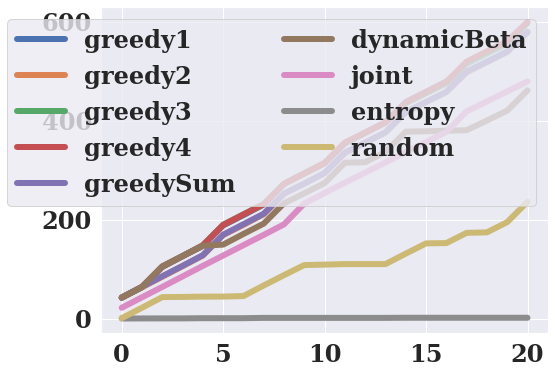

In [21]:
plt.figure(figsize=(8, 6))

plt.plot(greedy_IG_sum_trail_1, label='greedy1')
plt.plot(greedy_IG_sum_trail_2, label='greedy2')
plt.plot(greedy_IG_sum_trail_3, label='greedy3')
plt.plot(greedy_IG_sum_trail_4, label='greedy4')
plt.plot(greedy_IGsum_sum_trail, label='greedySum')
plt.plot(dynamic_beta_sum_trail, label='dynamicBeta')

plt.plot(joint_IG_sum_trail, label='joint')
plt.plot(entropy_IG_sum_trail, label='entropy')
plt.plot(rand_IG_sum_trail, label='random')

plt.legend(loc='upper left', ncol=2)
plt.legend(ncol=2)
plt.show()

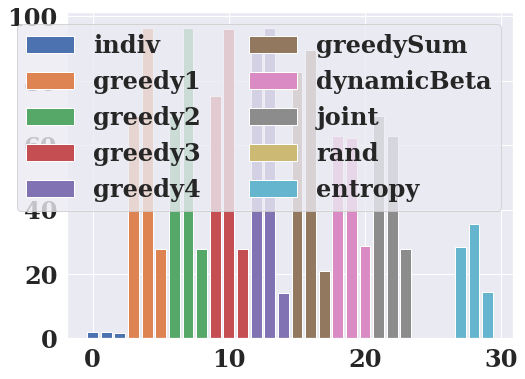

In [26]:
plt.figure(figsize=(8, 6))

pos = 0

ind_IG_sep_last = [ind_greedy_IG_trails[i][-1] for i in range(n)]
plt.bar(np.arange(n) + pos*n, ind_IG_sep_last, label='indiv')
pos += 1

for i, IG_sep_trail in enumerate([greedy_IG_sep_trail_1, greedy_IG_sep_trail_2, greedy_IG_sep_trail_3, greedy_IG_sep_trail_4]):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label='greedy'+str(i+1))
    pos += 1

for IG_sep_trail, name in zip([greedy_IGsum_sep_trail, dynamic_beta_sep_trail, joint_IG_sep_trail, entropy_IG_sep_trail, rand_IG_sep_trail], 
                              ['greedySum', 'dynamicBeta', 'joint','rand','entropy']):
    plt.bar(np.arange(n)+pos*n, IG_sep_trail[-1], label=name)
    pos+=1
    

plt.legend(ncol=2)
plt.show()